<a href="https://colab.research.google.com/github/sam134-eng/ImplementingReinforcement-learning-on-Algorithmic-Trading/blob/main/RL_Finance_research_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym-anytrading
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 3.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
#Stable Baseline3 for RL
from stable_baselines3 import PPO , DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
import gym_anytrading
#Computing Sharpe ratio
from gym_anytrading.envs import StocksEnv
#Evaluation metrics
#Computing Sharpe ratio
def sharpe_ratio(returns, risk_free= 0.0, annual_factor=252):
  excess_ret = returns - risk_free
  return np.mean(excess_ret) / (np.std(excess_ret) + 1e-9) * np.sqrt(annual_factor)
#Computing Maximum Drawdown
def max_drawdown(equity_curve):
    roll_max= np.maximum.accumulate(equity_curve)
    drawdown= (equity_curve-roll_max)/ roll_max
    return drawdown.min()

from dataclasses import dataclass

@dataclass
class RegimeSplit:
    """
    Defines regime-aware time slices for Train / Validation / Test.
    """
    train_start: str = "2012-01-01"
    train_end:   str = "2019-12-31"
    val_start:   str = "2020-01-01"
    val_end:     str = "2021-12-31"
    test_start:  str = "2022-01-01"
    test_end:    str = "2024-01-01"




Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
#Using RegimeSplit class for data slicing
regimes=RegimeSplit()
df = yf.download("AAPL", regimes.train_start, regimes.test_end)
def slice_df(df, start, end):
   return df.query("@start <= Date < @end").reset_index(drop=True)
df_train = slice_df(df, regimes.train_start, regimes.train_end)
df_val = slice_df(df, regimes.val_start, regimes.val_end)
df_test = slice_df(df, regimes.test_start, regimes.test_end)
print("train:", df_train)
print("val:", df_val)
print("test:", df_test)

/tmp/ipython-input-139970487.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", regimes.train_start, regimes.test_end)
[*********************100%***********************]  1 of 1 completed

train: Price       Close       High        Low       Open     Volume
Ticker       AAPL       AAPL       AAPL       AAPL       AAPL
0       12.345171  12.383297  12.278227  12.290235  302220800
1       12.411513  12.448739  12.286630  12.308244  260022000
2       12.549312  12.564922  12.388403  12.456850  271269600
3       12.680497  12.691004  12.585033  12.601544  318292800
4       12.660384  12.841105  12.648976  12.773561  394024400
...           ...        ...        ...        ...        ...
2006    68.589775  68.650153  67.713081  67.751724   98572000
2007    68.654976  68.804720  68.328939  68.756415   48478800
2008    70.017105  70.034013  68.758823  68.787804   93121200
2009    69.990562  70.997676  69.584822  70.309362  146266000
2010    70.405952  70.688526  68.884422  69.908436  144114400

[2011 rows x 5 columns]
val: Price        Close        High         Low        Open     Volume
Ticker        AAPL        AAPL        AAPL        AAPL       AAPL
0        72.538528   72.5

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
df.head()


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2012-01-03,12.345171,12.383297,12.278227,12.290235,302220800
2012-01-04,12.411513,12.448739,12.286630,12.308244,260022000
2012-01-05,12.549312,12.564922,12.388403,12.456850,271269600
2012-01-06,12.680497,12.691004,12.585033,12.601544,318292800
2012-01-09,12.660384,12.841105,12.648976,12.773561,394024400


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


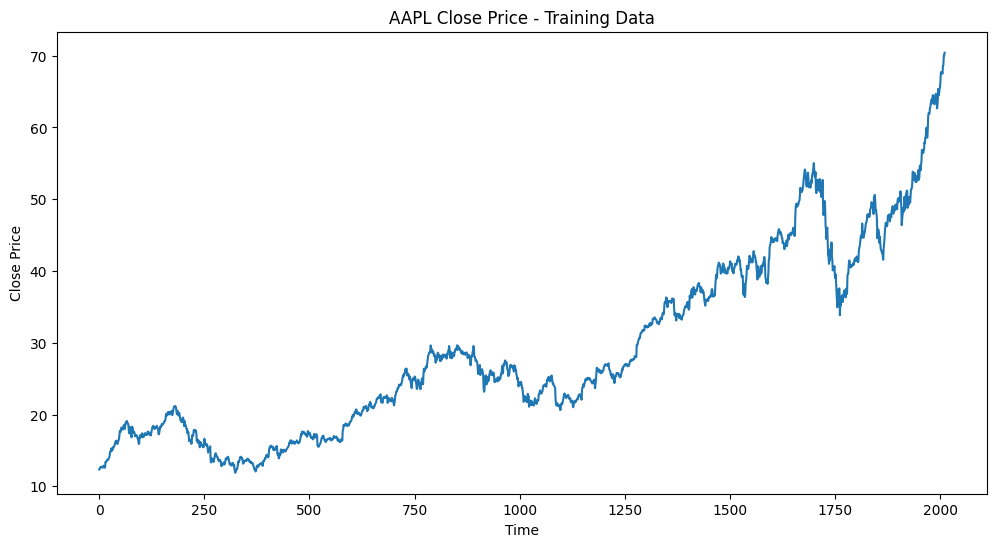

In [5]:
#Plot showing the close price during training period
plt.figure(figsize=(12, 6))
plt.plot(df_train['Close'])
plt.title('AAPL Close Price - Training Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()
# This plot shows the closing price of AAPL during the training period.